## Before running this notebook

Be sure to install the necessary prerequisites. If you have the corresponding requirements.txt textfile in the same directory as this notebook, the run the following command in your terminal:

```
$ pip3 install -r requirements.txt --user
```

In [159]:
!pip install umap-learn
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Parameters for this notebook

Be sure to set the parameters according to the directory details where the image database resides in.

An explanation on the directories:

nipg-board-v3 **This is the location of our NIPGBoard repository.**  
             |  
             |---- tutorials   **This is where we are now, running this notebook.**  
             |  
             | ...  
             
and a completely different directory somewhere else  

LOGDIR **A certain dataset, research project to be displayed in NIPGBoard will be generated here, independently of our NIPGBoard installation**  
      |  
      |----- image_folder  **The name of the folder that hold the images to be parsed.**  
      |  
      |----- embedding_folder **The name of the folder that will hold the embedding after parsing.**  
      |  
      |----- video_folder **If we want to use a video player, place the videos here.**  
      |  
      | ...  
      
The reason the above folder structure is required is to host them with a webservice for fast loading on client end.

**IMPORTANT:**
**Also be sure to look at the [Configuration chapter](#config) to set the algorithm_path configuration properly if you want to execute a training algorithm.**



```
# This is formatted as code
```

## Import library

In [160]:
import os
import sys
import numpy as np
import shutil
import scipy
import json
from PIL import Image, ImageFile
import itertools
import cv2
import pandas as pd
from keras import models,layers
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169
from tensorflow import keras 
import random


# import tensorflow.contrib.slim as slim
# import tensorflow.contrib.slim.nets as nets
# import tensorflow as tf
import glob
import h5py
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.contrib.tensorboard.plugins import projector

from tensorflow.keras.models import load_model
import h5py

ImageFile.LOAD_TRUNCATED_IMAGES = True



In [161]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing


In [162]:
tf.__version__

'1.14.0'

## Read test,train, subset train data(TN/FN)

In [163]:
logdir = "/home/user/logdir" #This is the ABSOLUTE path to the database directory. Tensorboard and NIPGBoard

# image_folder_train_subset= "subset_train_TN_FN" #Within the logdir, this folder contains the images to be parsed.
image_folder_test="subset_test_1298"
image_folder_train_all="subset_train_1500"
# test_folder="test_data"

embedding_folder = "embedding" #Within the logdir, this folder will contain the embedding data.

video_folder = "video" #Within the logdir, this folder will contain the videos for the video player.
algorithm_path="/home/user/nipg-board-v3/algorithms"

# Helper functions for  loading /preparing data

The following function we define to format the individual images to a size that the VGG16 model requires as input. **Please either format RGBA images to RGB if you are using an RGBA image dataset, or change the channel numbers to 4 in each corresponding notebook cell.**

In [164]:


def formatImage(im):
#     bgr = im.split()
#     im = Image.merge("RGB", (bgr[2], bgr[1], bgr[0]))
#     im = im.resize((380, 380), Image.ANTIALIAS)
    return np.asarray(im)

def preprocess_data(logdir,image_folder):
    labels=[]
    X_train=[]
    image_file_name=[]
    
    png_files = glob.glob(os.path.join(logdir, image_folder, '*png'))
    jpg_files = glob.glob(os.path.join(logdir, image_folder, '*jpg'))
    sprite = os.path.join(logdir, image_folder, 'sprite.png')

    if sprite in png_files:
        png_files.remove(sprite)
    image_files = sorted(png_files + jpg_files)
    
    
    for i in range(len(image_files)):
        image_names=image_files[i].split("/")[-1]
        image_file_name.append(image_names)
        train= formatImage(Image.open(image_files[i]))
        labels.append(os.path.basename(image_files[i]).split('_')[0])
        X_train.append(train)
#     X_train=X_train/255.
        
    
    return X_train,labels
    
    






# Define custom Pytorch Model

In [165]:
#Pytorch Pret-trained model


# Copyright (C) Eötvös Loránd University. All rights reserved.
# No one may reproduce, distribute, or create derivative works from this work.
# Degetel may use this software according to the terms of the negotiated
# license agreement, see "license.pdf" in the root directory of this software.

# standard library
import io
from types import SimpleNamespace
from typing import List, Dict
from pathlib import Path

# common numerical and scientific libraries
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import albumentations
import geffnet
from resnest.torch import resnest101
from pretrainedmodels import se_resnext101_32x4d

# other common libraries
from tqdm import tqdm

def get_modelspec(model_n):
    """return SimpleNamespace instance with attrs set"""
    data = pd.read_csv(io.StringIO("""
m  kernel_type                     arxiv_m data imgsz init_lr
01 9c_meta_b3_768_512_ext_18ep           1  768   512    3e-5
02 9c_b4ns_2e_896_ext_15ep               5 1024   896    2e-5
03 9c_b4ns_448_ext_15ep-newfold          6  512   448    3e-5
04 9c_b4ns_768_640_ext_15ep              2  768   640    3e-5
05 9c_b4ns_768_768_ext_15ep              3  768   768    3e-5
06 9c_meta_b4ns_640_ext_15ep             4  768   640    3e-5
07 4c_b5ns_1.5e_640_ext_15ep             9  768   640  1.5e-5
08 9c_b5ns_1.5e_640_ext_15ep             8  768   640  1.5e-5
09 9c_b5ns_448_ext_15ep-newfold         10  512   448    3e-5
10 9c_meta128_32_b5ns_384_ext_15ep       7  512   384    3e-5
11 9c_b6ns_448_ext_15ep-newfold         13  512   448    3e-5
12 9c_b6ns_576_ext_15ep_oldfold         12  768   576    3e-5
13 9c_b6ns_640_ext_15ep                 11  768   640    3e-5
14 9c_b7ns_1e_576_ext_15ep_oldfold      15  768   576    1e-5
15 9c_b7ns_1e_640_ext_15ep              16  768   640    1e-5
16 9c_meta_1.5e-5_b7ns_384_ext_15ep     14  512   384    3e-5
17 9c_nest101_2e_640_ext_15ep           18  768   640    2e-5
18 9c_se_x101_640_ext_15ep              17  768   640    3e-5
21 9c_b4ns_380_ext_15ep                  0  512   380    3e-5
"""), delim_whitespace=True, dtype={'m':str}).set_index('m')
    return SimpleNamespace(**data.loc[model_n])


net_type_dict = {
        '_b3_':      'efficientnet_b3',
        '_b4ns_':    'tf_efficientnet_b4_ns',
        '_b5ns_':    'tf_efficientnet_b5_ns',
        '_b6ns_':    'tf_efficientnet_b6_ns',
        '_b7ns_':    'tf_efficientnet_b7_ns',
        '_nest101_': 'resnest101',
        '_se_x101_': 'seresnext101',
        }

######## dataset

class PredictDataset(Dataset):
    def __init__(self, images, metas, use_meta, image_size, data_folder):

        self.images = images
        self.metas = metas
        
        #assert len(self.images) == len(self.metas)
        self.use_meta = use_meta
        self.data_folder = data_folder
        self.transform = albumentations.Compose([
            albumentations.Resize(image_size, image_size),
            albumentations.Normalize(),
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):

        image = self.images[index]
        

        res = self.transform(image=image)
        
        image = res['image'].astype(np.float32)

        image = image.transpose(2, 0, 1)
        

        if self.use_meta:
            inp_meta = self.metas[index]
            sex = {'male': 1, 'female': 0}.get(inp_meta['sex'], -1)
            if inp_meta['age'] is not None:
                age_approx = inp_meta['age'] / 90
            else:
                age_approx = 0
            n_images = inp_meta.get('n_images', 1)
            n_images = np.log1p(n_images)
            image_size = {
                    512: 10.989,
                    768: 11.590,
                    1024: 0,    # no meta for data_folder==1024 model
                    }[self.data_folder]
            # site, if present
            site_value = inp_meta.get('site')
            try:
                site_i = ['anterior torso', 'head/neck', 'lateral torso',
                    'lower extremity', 'oral/genital', 'palms/soles',
                    'posterior torso', 'torso', 'upper extremity',
                    ].index(site_value)
            except ValueError:
                site_i = 9
            site = [0]*10
            site[site_i] = 1
            meta = [sex, age_approx, n_images, image_size] + site
        else:
            meta = 0.
        data = (torch.tensor(image).float(), torch.tensor(meta).float())

        return data




######## models

sigmoid = nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)


class Effnet_Melanoma(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False):
        super(Effnet_Melanoma, self).__init__()
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type, pretrained=pretrained)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.enet.classifier.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            in_ch += n_meta_dim[1]
        
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out


class Resnest_Melanoma(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False):
        super(Resnest_Melanoma, self).__init__()
        self.n_meta_features = n_meta_features
        self.enet = resnest101(pretrained=pretrained)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.enet.fc.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            in_ch += n_meta_dim[1]
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.fc = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out


class Seresnext_Melanoma(nn.Module):
    def __init__(self, enet_type, out_dim, n_meta_features=0, n_meta_dim=[512, 128], pretrained=False):
        super(Seresnext_Melanoma, self).__init__()
        self.n_meta_features = n_meta_features
        if pretrained:
            self.enet = se_resnext101_32x4d(num_classes=1000, pretrained='imagenet')
        else:
            self.enet = se_resnext101_32x4d(num_classes=1000, pretrained=None)
        self.enet.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        in_ch = self.enet.last_linear.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                Swish_Module(),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                Swish_Module(),
            )
            in_ch += n_meta_dim[1]
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.last_linear = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        out /= len(self.dropouts)
        return out

########


class KWClassifier:
    """Classifier with 5 cv-folds of the same deepnet"""

    def __init__(self,
            model_n,            # str '01'..'18', or int 1 <= model_n <= 18
            weights_dir,        # if str of Path: load models for this directory
                                # if None: leave models uninitialized
            device = 'cuda',     # 'cpu' or 'cuda'
            ):
        # process parameters
        if isinstance(model_n, int):
            model_n = '{:02d}'.format(model_n)
        self.model_n = model_n
        self.device = torch.device(device)
        print ("dddddeeeeeeeeeevice",self.device)

        # obtain further parameters from modelspec
        spec = get_modelspec(self.model_n)
        self.kernel_type = spec.kernel_type
        self.data_folder = spec.data
        self.image_size = spec.imgsz
        # self.net_type
        for key, value in net_type_dict.items():
            if key in self.kernel_type:
                self.net_type = value
                break
        else:
            raise ValueError(f'{self.kernel_type}: unknown net_type')
        self.init_lr = spec.init_lr
        # self.out_dim
        if self.kernel_type.startswith('9c_'):
            self.out_dim = 9
        elif self.kernel_type.startswith('4c_'):
            self.out_dim = 4
        else:
            raise ValueError(f'{self.kernel_type}: unknown out_dim')
        # self.default_n_epochs
        if '_15ep' in self.kernel_type:
            self.default_n_epochs = 15
        elif '_18ep' in self.kernel_type:
            self.default_n_epochs = 18
        else:
            raise ValueError(f'{self.kernel_type}: unknown default_n_epochs')
        self.use_meta = ('meta' in self.kernel_type)
        self.n_meta_features = 14 if self.use_meta else 0
        self.n_meta_dim = (512, 128)
        if '_meta128_32_' in self.kernel_type:
            self.n_meta_dim = (128, 32)
        # mel_idx, based on out_dim
        if self.out_dim == 9:
            diagnosis2idx = {
                    'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'SCC': 4, 'VASC': 5,
                    'MEL': 6, 'NV': 7, 'UNK': 8,
                    }
        elif self.out_dim == 4:
            diagnosis2idx = {
                    'AK': 3, 'BCC': 3, 'BKL': 0, 'DF': 3, 'SCC': 3, 'VASC': 3,
                    'MEL': 1, 'NV': 2, 'UNK': 3,
                    }
        self.mel_idx = diagnosis2idx['MEL']

        self.models = None
        if weights_dir is not None:
            self.build_and_load(weights_dir)
#             a=self.models
#             print ("models",list(a[0].children())[-2])

    def _build_model(self, pretrained=False):
        """build single model, return it"""
        if self.net_type == 'resnest101':
            ModelClass = Resnest_Melanoma
        elif self.net_type == 'seresnext101':
            ModelClass = Seresnext_Melanoma
        elif 'efficientnet' in self.net_type:
            ModelClass = Effnet_Melanoma
        else:
            raise NotImplementedError()

        model = ModelClass(
            self.net_type,
            n_meta_features = self.n_meta_features,
            n_meta_dim = self.n_meta_dim,
            out_dim = self.out_dim,
            pretrained = pretrained,
        )
        return model

    def build_and_load(self, weights_dir, version='final'):
        """build 5 models and load weights"""
        self.models = []
        for fold in range(1):
            model = self._build_model()
            model.to(self.device)
            path = (Path(weights_dir)) 
#                     / f'weights_m{self.model_n}_f{fold}_{version}.pth')
            if not path.exists():
                print(f'skip {path}')
                self.models.append(None)
                continue
            print(f'load {path} ...')
            try:    # single GPU
                model.load_state_dict(torch.load(path), strict=True)
            except: # multi GPU
                state_dict = torch.load(path)
                # strip leading "module." from keys
                state_dict = { k_[7:] if k_.startswith('module.') else k_: 
                        state_dict[k_] for k_ in state_dict.keys() }
                model.load_state_dict(state_dict, strict=True)
#             print (model)

            self.models.append(model)
#             self.models=
            
 

    def predict_softmax(self, list_of_images:List[np.ndarray],
            list_of_meta:List[Dict],
            batch_size=16,
            n_workers=1,
            ) -> np.ndarray:
        """predict on a list of images+meta
        
        list_of_meta contains dicts per image, eg:
            {'sex': 'male', 'age':45} or {'sex':None, 'age':None}
        """
        dataset = PredictDataset(list_of_images, list_of_meta,
                self.use_meta, self.image_size, self.data_folder)
#         print (dataset)
        loader = torch.utils.data.DataLoader(dataset,
                batch_size=batch_size,
                num_workers=n_workers,
                )
#         print (loader)
        softmax = self._predict(loader)
#         print ("softmax.............",softmax)
        return softmax

    @classmethod
    def get_trans(cls, img, I):
        """helper function: simple augmentation: flip/transpose"""
        if I >= 4:
            img = img.transpose(2, 3)
        if I % 4 == 0:
            return img
        elif I % 4 == 1:
            return img.flip(2)
        elif I % 4 == 2:
            return img.flip(3)
        elif I % 4 == 3:
            return img.flip(2).flip(3)

    def _predict(self,
        loader,
        models = None,  # default: self.models
        n_tta = 8, # number of flip/transpose trials for test time augment
        use_tqdm = False,
        ):
        """return prediction as np.array"""
        # params
        if models is None:
            models = self.models
        if use_tqdm:
            loader = tqdm(loader)
        #
        for model in models:
            try:

                model.eval()
            except:
                raise RuntimeError('missing or illegal model')
        softmax = []
        with torch.no_grad():
            for data, meta in loader:
                data, meta = data.to(self.device), meta.to(self.device)  
                for model in models:
                    model=list(model.children())[-3]


                    for I in range(n_tta):

                        logits = model(self.get_trans(data, I))
#                         print (logits)
     
                
#                 softmax_batch = torch.zeros((data.shape[0], self.out_dim))
#                 softmax_batch = softmax_batch.to(self.device)
#                 for model in models:
#                     for I in range(n_tta):
#                         logits = model(self.get_trans(data, I), meta)
#                         softmax_batch += logits.softmax(1)
#                 softmax_batch /= n_tta
#                 softmax_batch /= len(models)
                softmax.append(logits.detach().cpu())
#                 print (softmax)
        print ("FFFFFFFFFFFFFFIIIIIIIIIIIIINNNNNNNNNNNNNIIIIIIIIIIIIIIIISSSSSSSSSSSSSHHHHHHH")
        return torch.cat(softmax).numpy()

# vim: set sw=4 sts=4 expandtab :


In [166]:
model_n="21"
weights_dir="/home/user/nipg-board-v3/tutorials/isic2019/weights_m21_f0_final.pth"
m_c=KWClassifier(model_n,weights_dir)

dddddeeeeeeeeeevice cuda
load /home/user/nipg-board-v3/tutorials/isic2019/weights_m21_f0_final.pth ...


## data loading for test/train/subset_train

In [167]:
# X_train_subset,y_train_subset=preprocess_data(logdir,image_folder_train_subset)

X_train_all,y_train_all=preprocess_data(logdir,image_folder_train_all)

X_test,y_test=preprocess_data(logdir,image_folder_test)

In [168]:
print (len(X_train_all),len(y_train_all))
print (len(X_test),len(y_test))

1500 1500
1298 1298


In [169]:
# # print("Training Data Shape: ", X_train_subset.shape)
# print("Test Data Shape: ", X_test.shape)
# print("Training subset Data Shape: ", X_train_all.shape)


In [170]:
# X_train_all_scale=X_train_all[0]/255
# X_test_scale=X_test[0]/255.


In [171]:
# X_train_all_scale,X_test_scale

In [172]:
# X_train_all

## Get embedding

In [173]:
# # Get embedding for subset_train data
# list_of_images=X_train_subset
# list_of_meta=None
# subset_train_intermediate_output=m_c.predict_softmax(X_train_subset,list_of_meta)

In [174]:
# Get embedding for train data
list_of_images=X_train_all
list_of_meta=None
train_intermediate_output=m_c.predict_softmax(X_train_all,list_of_meta)

FFFFFFFFFFFFFFIIIIIIIIIIIIINNNNNNNNNNNNNIIIIIIIIIIIIIIIISSSSSSSSSSSSSHHHHHHH


In [175]:
train_intermediate_output

array([[-1.2881226e-06, -1.4180243e-01, -1.7136700e-01, ...,
        -6.4151455e-03, -2.0500131e-01, -5.3461950e-02],
       [ 3.2885951e-01,  1.9797908e-01, -1.1318554e-01, ...,
         1.4859173e-01,  3.1911068e-02,  8.4175640e-01],
       [ 3.5919353e-01,  7.2506376e-02,  1.7953494e-01, ...,
         4.2781763e-02,  9.8786846e-02,  1.4964071e-02],
       ...,
       [-1.3478723e-02,  2.1581938e-02,  8.6443633e-02, ...,
         8.7275960e-02,  1.1951666e-01,  1.2430302e-01],
       [-1.5476479e-03,  4.3176776e-01, -6.5734945e-02, ...,
         6.5296054e-02,  3.2755238e-01, -1.2424835e-01],
       [ 8.8115245e-02,  1.0368474e-01,  8.1646733e-02, ...,
         2.9654652e-02, -2.6552120e-02,  1.8471462e-01]], dtype=float32)

In [176]:
# Get embedding for test data
list_of_images=X_test
list_of_meta=None
test_intermediate_output=m_c.predict_softmax(X_test,list_of_meta)

FFFFFFFFFFFFFFIIIIIIIIIIIIINNNNNNNNNNNNNIIIIIIIIIIIIIIIISSSSSSSSSSSSSHHHHHHH


In [177]:
test_intermediate_output

array([[ 0.0775619 , -0.12141098,  0.12804747, ...,  0.02569612,
        -0.17984279,  0.1577469 ],
       [ 0.10973807,  0.11958305, -0.07967456, ..., -0.05357769,
         0.04584774,  0.22879192],
       [ 0.1222798 , -0.0219185 ,  0.33628884, ...,  0.12804413,
        -0.13688333,  0.35983458],
       ...,
       [-0.0291985 ,  0.07852304,  0.0155777 , ..., -0.02929768,
        -0.06334899, -0.10127983],
       [ 0.17319544, -0.08895836, -0.07322645, ..., -0.07105819,
        -0.01136518,  0.2163865 ],
       [-0.01927109,  0.16775754,  0.03730754, ..., -0.0382287 ,
         0.03737964, -0.13274202]], dtype=float32)

#  Compute UMAP


###### standrize the intermediate output before input to umap


In [178]:
# scaler = preprocessing.StandardScaler().fit(subset_train_intermediate_output)
# subset_train_intermediate_output = scaler.transform(subset_train_intermediate_output) #subset
# scaler = preprocessing.StandardScaler().fit(train_intermediate_output)
# train_intermediate_output = scaler.transform(train_intermediate_output)
# test_intermediate_output = scaler.transform(test_intermediate_output)



In [179]:
labels = y_train_all
labels_text = np.array(y_train_all)
labels = np.where(labels_text=='FN', 0, labels_text)
labels = np.where(labels=='TN', 1, labels)

In [180]:
lables = labels.astype(np.int)
print(len(lables))

1500


In [181]:
# #umap parameter with labels
# n_neighbors=50
# n_components=3
# metric='euclidean'
# output_metric='euclidean'
# n_epochs=600
# learning_rate=0.1
# init='spectral'
# min_dist=0.2
# spread=1.
# low_memory=True
# local_connectivity=1
# repulsion_strength=2.
# negative_sample_rate=2
# transform_queue_size=2.
# target_metric='categorical' # Furthermore, if semi-supervised is required target values of -1 will be trated as unlabelled under the ‘categorical’ metric. If the target array takes continuous values (e.g. for a regression problem) then metric of ‘l1’ or ‘l2’ is probably more appropriate.
# verbose=False
# unique=False
# dens_lambda=2.
# random_state=42
# dens_var_shift=.01
# disconnection_distance=np.inf# Disconnect any vertices of distance greater than or equal to disconnection_distance when approximating the manifold via our k-nn graph. This is particularly useful in the case that you have a bounded metric. The UMAP assumption that we have a connected manifold can be problematic when you have points that are maximally different from all the rest of your data. The connected manifold assumption will make such points have perfect similarity to a random set of other points. Too many such points will artificially connect your space.
# transform_seed=42


# trans = umap.UMAP(n_neighbors=n_neighbors, 
#               n_components=n_components, metric=metric, 
#               output_metric=output_metric,
#               learning_rate=learning_rate, n_epochs=n_epochs, 
#               init=init, min_dist=min_dist,
#               spread=spread, low_memory=low_memory,
#               local_connectivity=local_connectivity, repulsion_strength=repulsion_strength,
#               negative_sample_rate=negative_sample_rate, transform_queue_size=transform_queue_size,
#               verbose=verbose,unique=unique,
#               dens_lambda=dens_lambda, dens_var_shift=dens_var_shift,
#               disconnection_distance=disconnection_distance,
#               random_state=random_state,transform_seed=transform_seed).fit(X=train_intermediate_output,y=lables)

# train_embedding_all=trans.transform(train_intermediate_output)
# test_embedding=trans.transform(test_intermediate_output)



In [194]:
# #define umap
def umap3d(m_c_predict_train,m_c_predict_test,n_components,n_neighbors,n_epochs):
    trans = umap.UMAP(n_components=n_components,n_neighbors=n_neighbors,n_epochs=n_epochs).fit(m_c_predict_train)
    train_embedding=trans.embedding_
    test_embedding=trans.transform(m_c_predict_test)
    return train_embedding,test_embedding

train_embedding,test_embedding= umap3d(train_intermediate_output,test_intermediate_output,3,43,500)
  

In [195]:
train_embedding

array([[10.073287 , 12.923591 ,  8.672927 ],
       [10.63158  , 12.648102 ,  9.791039 ],
       [ 8.938117 , 13.38383  ,  7.8196096],
       ...,
       [ 5.6817894, 10.10702  ,  8.761784 ],
       [ 5.8536305, 10.022981 ,  8.443933 ],
       [ 6.543916 ,  9.951368 ,  9.835186 ]], dtype=float32)

In [196]:
zipped_train=list(list(zip(train_embedding,y_train_all)))

# print (zipped_train)
#separate the FN and TN embeddings for visulalization purpose
FN_points_train=[]
TN_points_train=[]
for i in zipped_train:
    if i[1].split("_")[-1]=="FN":
        FN_points_train.append(i[0])
    if i[1].split("_")[-1]=="TN":
        TN_points_train.append(i[0])
FN_points_train=np.array(FN_points_train)
TN_points_train=np.array(TN_points_train)
        

zipped_test=list(list(zip(test_embedding,y_test)))
FN_points_test=[]
TN_points_test=[]
for i in zipped_test:
    if i[1].split("_")[-1]=="FN":
        FN_points_test.append(i[0])
    if i[1].split("_")[-1]=="TN":
        TN_points_test.append(i[0])
FN_points_test=np.array(FN_points_test)
TN_points_test=np.array(TN_points_test)




In [197]:
def Three_D_cluster(train_embedding_TN,train_embedding_FN,test_embedding_TN,test_embedding_FN):


    l=[]
    l1=[]
    l2=[]
    l3=[]
    
    x=train_embedding_FN[:,0]
    y=train_embedding_FN[:,1]
    z=train_embedding_FN[:,2]

    l.append([x,y,z,"train_FN"])
    
#     ------------------------------------------------------

    x1=train_embedding_TN[:,0]
    y1=train_embedding_TN[:,1]
    z1=train_embedding_TN[:,2]
    l1.append([x1,y1,z1,"train_TN"])
    
    #     ------------------------------------------------------


    x2=test_embedding_TN[:,0]
    y2=test_embedding_TN[:,1]
    z2=test_embedding_TN[:,2]


    l2.append([x2,y2,z2,"test_TN"])
    #     ------------------------------------------------------

    
    x3=test_embedding_FN[:,0]
    y3=test_embedding_FN[:,1]
    z3=test_embedding_FN[:,2]


    l3.append([x3,y3,z3,"test_FN"])
    
#     #     ------------------------------------------------------


    fig = plt.figure(figsize = (10, 7),dpi=200)
    ax = fig.add_subplot(111,projection="3d")
#     ax.set_xlim(1,20)
#     ax.set_ylim(2,20)
#     ax.set_zlim(2,15)
    
    for i in l:  

        ax.scatter(i[0],i[1],i[2],label=i[3],s=7,color="blue")
        ax.legend(loc=2,fontsize=7)
    
    for i in l1:  

        ax.scatter(i[0],i[1],i[2],label=i[3],s=7,color="red")
        ax.legend(loc=2,fontsize=7)
#     for i in l2:  

#         ax.scatter(i[0],i[1],i[2],label=i[3],s=5,color="yellow")
#         ax.legend(loc=2,fontsize=7)
    
#     for i in l3:  

#         ax.scatter(i[0],i[1],i[2],label=i[3],s=5,color="green")
#         ax.legend(loc=2,fontsize=7)

1000
500


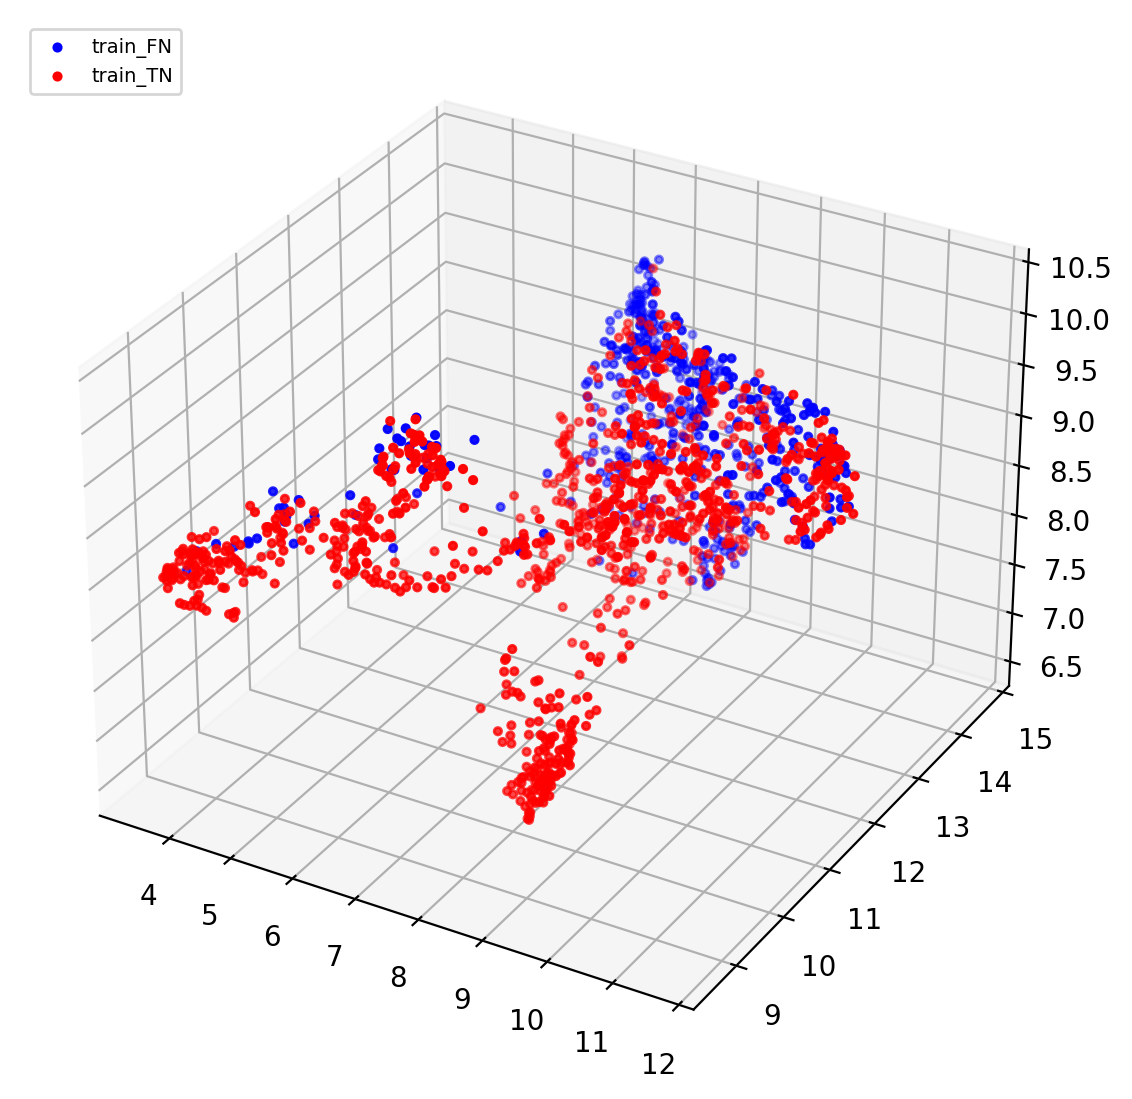

In [198]:
print (len(TN_points_train))
print (len(FN_points_train))
# 


Three_D_cluster(TN_points_train,FN_points_train,TN_points_test,FN_points_test)

In [202]:
pd.DataFrame(train_embedding).to_csv("train_embedding_1500_run2.csv")
pd.DataFrame(y_train_all).to_csv("train_embedding_label_1500_run2.csv")

pd.DataFrame(test_embedding).to_csv("test_embedding_run2.csv")
pd.DataFrame(y_test).to_csv("test_embedding_label_run2.csv")

